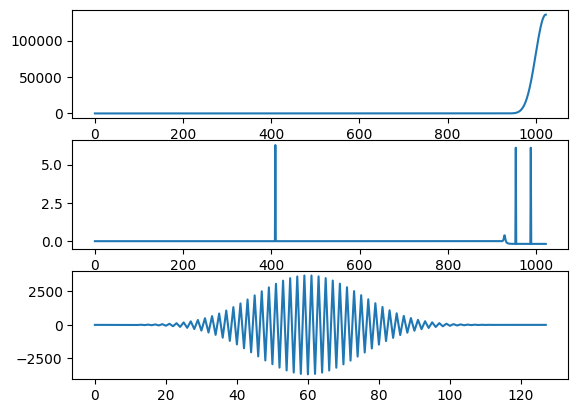

In [7]:
import numpy as np
from DistantSpeech.beamformer.utils import load_audio as audioread
from DistantSpeech.beamformer.utils import save_audio as audiowrite
from DistantSpeech.transform.multirate import frac_delay
delta = 2.5
N = 128
w_max=0.9
C=4

# constraints
N_C = int(C * N)
w = np.linspace(0, w_max * np.pi, N_C)[:, np.newaxis]

n = np.arange(N)

try:
    from cvxopt import solvers, matrix
except:
    raise ValueError(
        "To use the frac_delay function, the cvxopt module is necessary."
    )

f = np.concatenate((np.zeros(N), np.ones(1)))

A = []
b = []
for i in range(N_C):
    Anp = np.concatenate(
        ([np.cos(w[i] * n), -np.sin(w[i] * n)], [[0], [0]]), axis=1
    )
    Anp = np.concatenate(([-f], Anp), axis=0)
    A.append(matrix(Anp))
    b.append(
        matrix(np.concatenate(([0], np.cos(w[i] * delta), -np.sin(w[i] * delta))))
    )

solvers.options["show_progress"] = False
sol = solvers.socp(matrix(f), Gq=A, hq=b)

h = np.array(sol["x"])[:-1, 0]

import matplotlib.pyplot as plt
w = np.linspace(0, np.pi, 2*N_C)
F = np.exp(-1j*w[:,np.newaxis]*n)
Hd = np.exp(-1j*delta*w)
plt.figure()
plt.subplot(3,1,1)
plt.plot(np.abs(np.dot(F,h) - Hd))
plt.subplot(3,1,2)
plt.plot(np.diff(np.angle(np.dot(F,h))))
plt.subplot(3,1,3)
plt.plot(h)

In [9]:
data = audioread('/home/wangwei/work/DistantSpeech/samples/audio_samples/cleanspeech_aishell3.wav')
h1 = frac_delay(2, 40, w_max=0.9, C=4)
h2 = frac_delay(3, 40, w_max=0.9, C=4)
h3 = frac_delay(3.5, 40, w_max=0.9, C=4)
out1 = np.convolve(data, h1)
out2 = np.convolve(data, h2)
out3 = np.convolve(data, h3)
audiowrite('aec/out1.wav', out1)
audiowrite('aec/out2.wav', out2)
audiowrite('aec/out3.wav', out3)